# Predicting Stroke
Author: Necky Tran <br>
Date: 06/06/23

### Table of Contents

1. [Introduction](#Introduction)
2. [Wrangling](#Wrangling)
3. [Logistic Regression](#Logistic)
4. [SMOTE](#Smote)
5. [Summary](#Summary)

# Introduction
This notebook contains an analysis of a of a US Health Insurance Dataset. The dataset is sourced from Kaggle:
- 'https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset'

The dataset was cleaned and analyzed to generate a logistic model to predict likelyhood of stroke.

In [1]:
# load standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read in and check data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The data has been successfully loaded


# Wrangling
- Exploratory Data Analysis
    - Deal with NaNs and Duplicates
    - Explore each column
    - Convert categorical columns into  numerical

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 5110 rows and 12 columns

The [bmi] column has some missing values, we can explore this further 

In [4]:
# Check which columns have NaN values
#.isna() returns a dataframe of T/F for any element that is missing
#.any() tells us if there are any Trues in that column
df.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [5]:
# calculate percentage of missing data
df.isna().mean()*100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

The BMI column has some NAs, about 4% of the total data. We can explore it futher to make a decision one whether to drop or impute <br>

In [6]:
# find rows of data where bmi is missing
df[df['bmi'].isna()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


There are 201 rows where the bmi value is missing. <br>


Look into the distribution of the BMI column:
- so we can either impute with mean or median values

 28.89 is the mean BMI
 28.1 is the median BMI


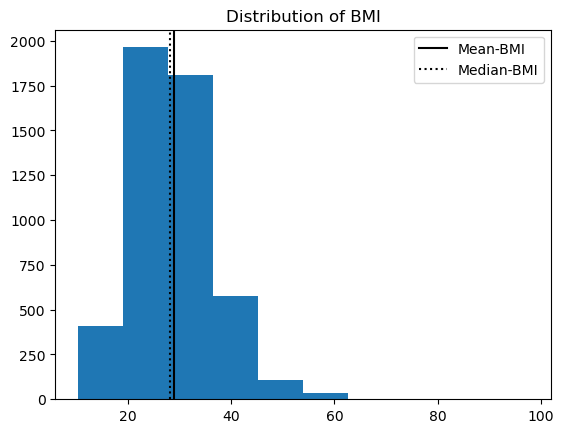

In [7]:
# histogram of BMI
plt.hist(df['bmi'])

# add lines for the mean and median values
plt.axvline(df['bmi'].mean(),linestyle = 'solid',label = "Mean-BMI", color = 'black')
plt.axvline(df['bmi'].median(),linestyle = 'dotted',label = "Median-BMI", color = 'black')

# title
plt.title('Distribution of BMI')

# legend
plt.legend(loc='upper right');

# print the mean BMI
print(f" {round(df['bmi'].mean(), 2)} is the mean BMI")

# print the median BMI
print(f" {df['bmi'].median()} is the median BMI")

The mean and median BMI are very similar which means this data is symetrically distributed around a central value. There are no extreme outliers pulling the mean away from the median. It would be appropriate to use a mean imputation on the missing data.

Lets check for duplications before we impute

In [8]:
#check for duplicated values
df.duplicated().sum()

0

There are no duplicated rows in the Dataset

Impute missing [bmi] data with the mean

In [9]:
# mean imputation
df['bmi'] = np.where(df['bmi'].isna(), 28, df['bmi'])

In [10]:
# check for missing values again
df['bmi'].isna().sum()

0

The missing values have been successfully imputed with the mean.

Explore the columns of the dataset by visualizing each invididually

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None


Columns [gender], [every_married], [work_type], [Residence_type], and [smoking_status] are object columns that should be numerically encoded

C:\Users\trann\AppData\Local\Temp\ipykernel_20520\2383523496.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df['age'], kde=True, palette=palette)
C:\Users\trann\AppData\Local\Temp\ipykernel_20520\2383523496.py:57: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df['avg_glucose_level'], kde=True, palette=palette)  # Using a different color for the plot
C:\Users\trann\AppData\Local\Temp\ipykernel_20520\2383523496.py:67: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df['bmi'], kde=True, palette=palette)  # Using a different color for the plot


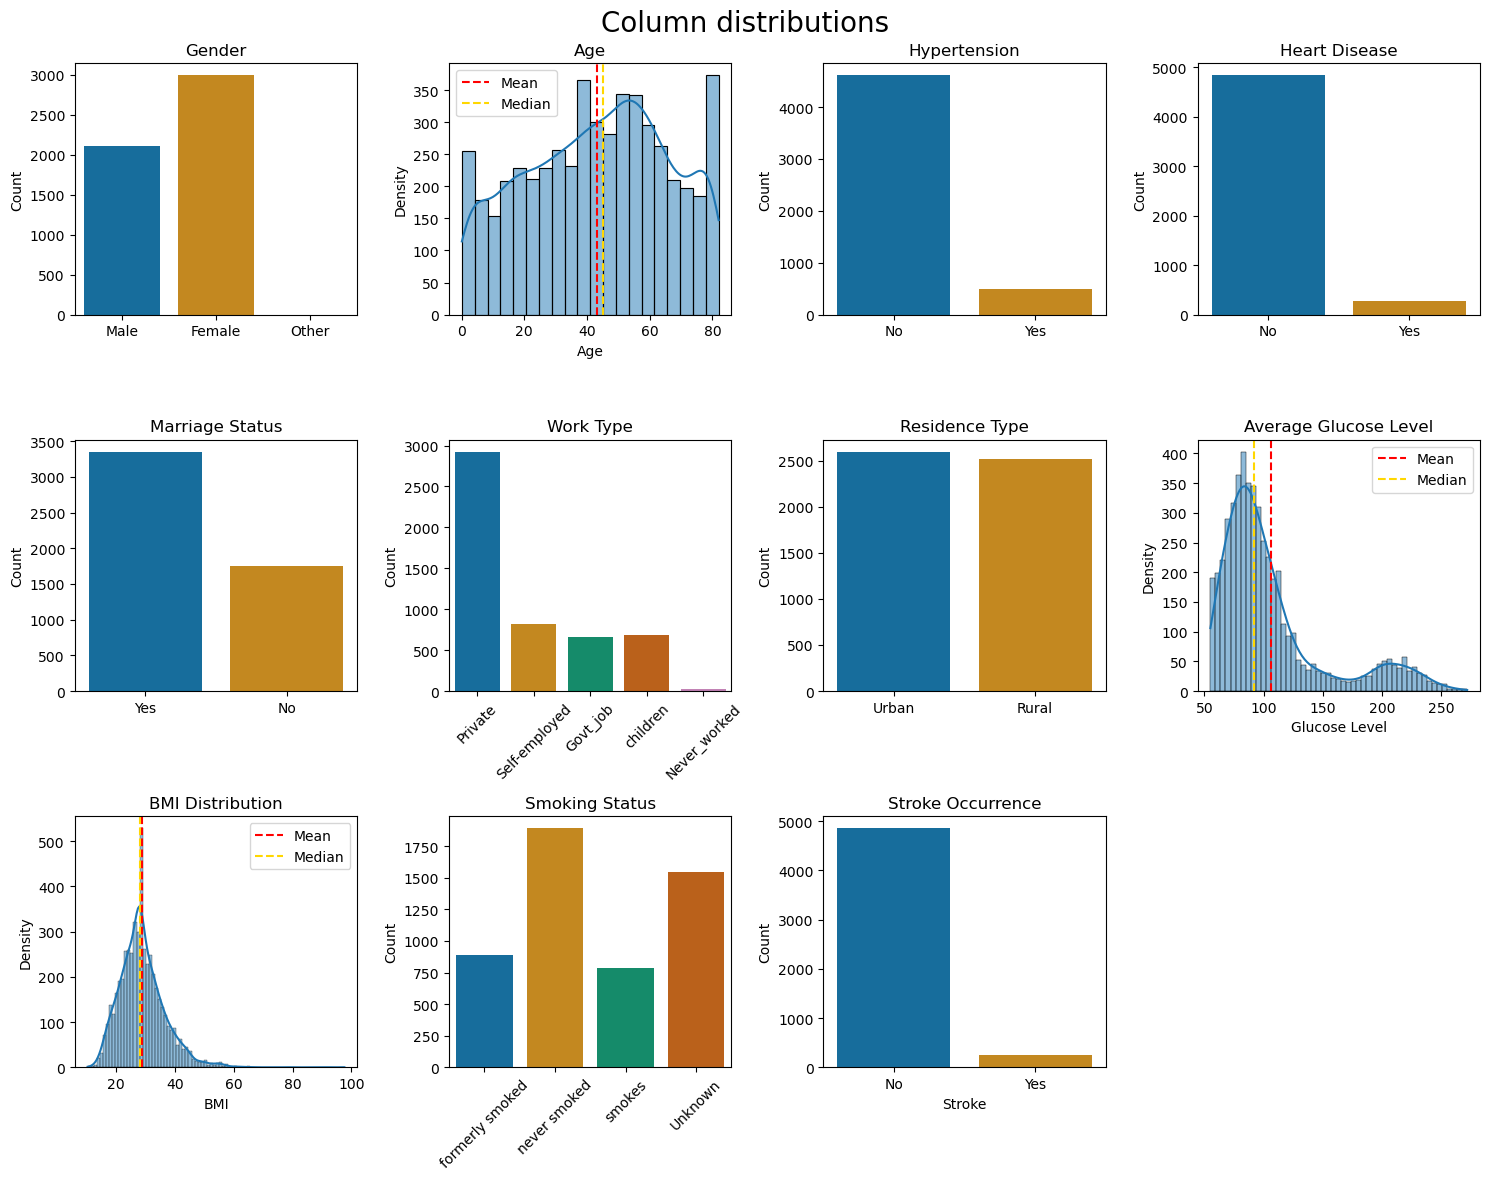

In [12]:
# explore distribution of every column

plt.subplots(3,4, figsize = (15,12))
plt.suptitle('Column distributions', size =20)
palette = sns.color_palette("colorblind")

# Gender
plt.subplot(3, 4, 1)
sns.countplot(x=df['gender'], palette=palette)
plt.title('Gender')
plt.xlabel('')
plt.ylabel('Count')

plt.subplot(3, 4, 2)
sns.histplot(x=df['age'], kde=True, palette=palette)
plt.axvline(df['age'].mean(), c='red', linestyle='--', label='Mean')
plt.axvline(df['age'].median(), c='gold', linestyle='--', label='Median')
plt.legend()
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Density')

plt.subplot(3, 4, 3)
sns.countplot(x=df['hypertension'], palette=palette)  # Using a sequential color palette
plt.title('Hypertension')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

plt.subplot(3, 4, 4)
sns.countplot(x=df['heart_disease'], palette=palette)  # Using a different color palette
plt.title('Heart Disease')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])  # Assuming the column values are binary (0 and 1)

plt.subplot(3, 4, 5)
sns.countplot(x=df['ever_married'], palette=palette)  # Using a different color palette
plt.title('Marriage Status')
plt.xlabel('')
plt.ylabel('Count')

plt.subplot(3, 4, 6)
sns.countplot(x=df['work_type'], palette=palette)  # Using a different color palette
plt.title('Work Type')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.subplot(3, 4, 7)
sns.countplot(x=df['Residence_type'], palette=palette)  # Using a different color palette
plt.title('Residence Type')
plt.xlabel('')
plt.ylabel('Count')

plt.subplot(3, 4, 8)
sns.histplot(x=df['avg_glucose_level'], kde=True, palette=palette)  # Using a different color for the plot
plt.axvline(df['avg_glucose_level'].mean(), c='red', linestyle='--', label='Mean')
plt.axvline(df['avg_glucose_level'].median(), c='gold', linestyle='--', label='Median')
plt.legend(loc='upper right')  # Adjust legend placement
plt.title('Average Glucose Level')
plt.xlabel('Glucose Level')
plt.ylabel('Density')
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.subplot(3, 4, 9)
sns.histplot(x=df['bmi'], kde=True, palette=palette)  # Using a different color for the plot
plt.axvline(df['bmi'].mean(), c='red', linestyle='--', label='Mean')
plt.axvline(df['bmi'].median(), c='gold', linestyle='--', label='Median')
plt.legend(loc='upper right')  # Adjust legend placement
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.subplot(3, 4, 10)
sns.countplot(x=df['smoking_status'], palette=palette)  # Using a different color palette
plt.title('Smoking Status')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.subplot(3, 4, 11)
sns.countplot(x=df['stroke'], palette=palette)  # Using a different color palette
plt.title('Stroke Occurrence')
plt.xlabel('Stroke')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])  # Assuming the column values are binary (0 and 1)
plt.tight_layout()  # Adjust layout to prevent overlapping

plt.subplot(3, 4, 12)
plt.axis('off')  # Turn off axis for the empty subplot

plt.tight_layout()

In [13]:
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

### Observations into the features: <br>
gender: more females than males in the dataset <br>
age: most ages are normally distributed around 40, there is a large count of 80+ people <br>
hypertension: most do not have hypertension <br>
heart_disease: most do not have heart disease <br>
ever_married: larger proportion of people are married <br>
work_type: majority of people are privately employed <br>
residence_type: the distribution between urban and rural residence is about equal <br>
avg_glucose_level: the distribution has a right skew, most are centered around the median (~80) <br>
bmi: looks normally distributed around a mean of ~29 (This column was mean imputed)<br>
smoking_status: most have never smoked or formerly smoked <br>
stroke: most have not experienced a stroke <br>


Our current target distribution is heavily skewed towards non-stroke cases. As a result, our model will exhibit a strong bias towards predicting no stroke, potentially leading to increased false negative predictions when applied to new and unseen data. To address this issue, we can rectify the imbalance using a scikit-learn package (SMOTE). Our initial approach will involve creating a base model first and then upsampling with SMOTE to achieve a more balanced and representative dataset<br>

Before modelling, create dummy variables out of all the categorical variables

In [14]:
# Get a list of all categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Display the encoded DataFrame
print(df_encoded)

         id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0      9046  67.0             0              1             228.69  36.6   
1     51676  61.0             0              0             202.21  28.0   
2     31112  80.0             0              1             105.92  32.5   
3     60182  49.0             0              0             171.23  34.4   
4      1665  79.0             1              0             174.12  24.0   
...     ...   ...           ...            ...                ...   ...   
5105  18234  80.0             1              0              83.75  28.0   
5106  44873  81.0             0              0             125.20  40.0   
5107  19723  35.0             0              0              82.99  30.6   
5108  37544  51.0             0              0             166.29  25.6   
5109  44679  44.0             0              0              85.28  26.2   

      stroke  gender_Male  gender_Other  ever_married_Yes  \
0          1            1             

In [15]:
# view new encoded dataframe
df_encoded.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,1,0,1,0,1,0,0,1,1,0,0
1,51676,61.0,0,0,202.21,28.0,1,0,0,1,0,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.5,1,1,0,1,0,1,0,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,0,0,0,1,0



Check for multicolinearity with a heatmap and remove highly correlated variables

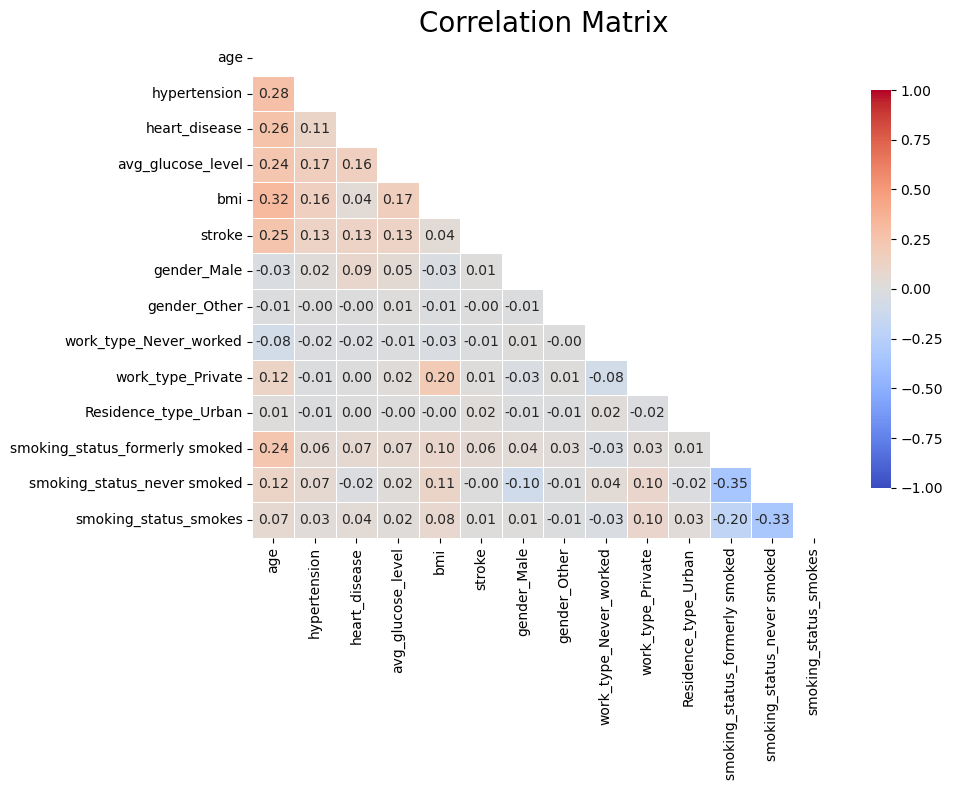

In [35]:
# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr().round(2),
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color map
            vmin=-1, vmax=1,  # Set color scale limits
            mask=np.triu(df_encoded.corr()),  # Mask upper triangle
            linewidths=0.5,  # Add linewidths between cells
            linecolor='white',  # Set linewidth color
            cbar_kws={'shrink': 0.8},  # Adjust colorbar size
            fmt=".2f")  # Format annotation values to 2 decimal places

# Set title and adjust font size
plt.title('Correlation Matrix', size=20)

# Rotate y-axis ticks for better readability
plt.yticks(rotation=0)

# Save figure to figure folder
plt.tight_layout()
plt.savefig('figures/cor_mat.png')
# Display the heatmap
plt.show()

### Observations into the features: <br>
[age] is positively correlated with [ever_married_yes] and negatively correlated with [work_type_children] <br>
[bmi] is correlated with positively correlated with [ever_married_yes] and negatively correlated with [work_type_children] <br>
[work_type_children] is negatively correlated with [ever_married_yes] and negatively correlated with [work_type_private] <br>

It looks likes stroke is slightly correlated with age which is correlated with bmi, heart disease, hypertension and avg_glucose_level. <br>
We can check the distributions of age by stroke status and see if there is a significant difference while keeping in mind that age is associated with other ailments

All the work types are negatively correlated with each other, it would be wise to remove some of them. From our countplot, most people work in the private sector. So we can remove all but the [work_type_private] as it hold the most data <br>

I will also remove [ever_married_yes] because it is correlated with age, and age is a feature i want to keep <br>

Also drop the [id] column


# Statistical Analysis
- look at distribution of age by stroke status

In [17]:
# get array of charges for smokers
stroke_yes = df[df['stroke'] == 1]['age']
# get array of charges for non-smokers
stroke_no = df[df['stroke'] == 0]['age']

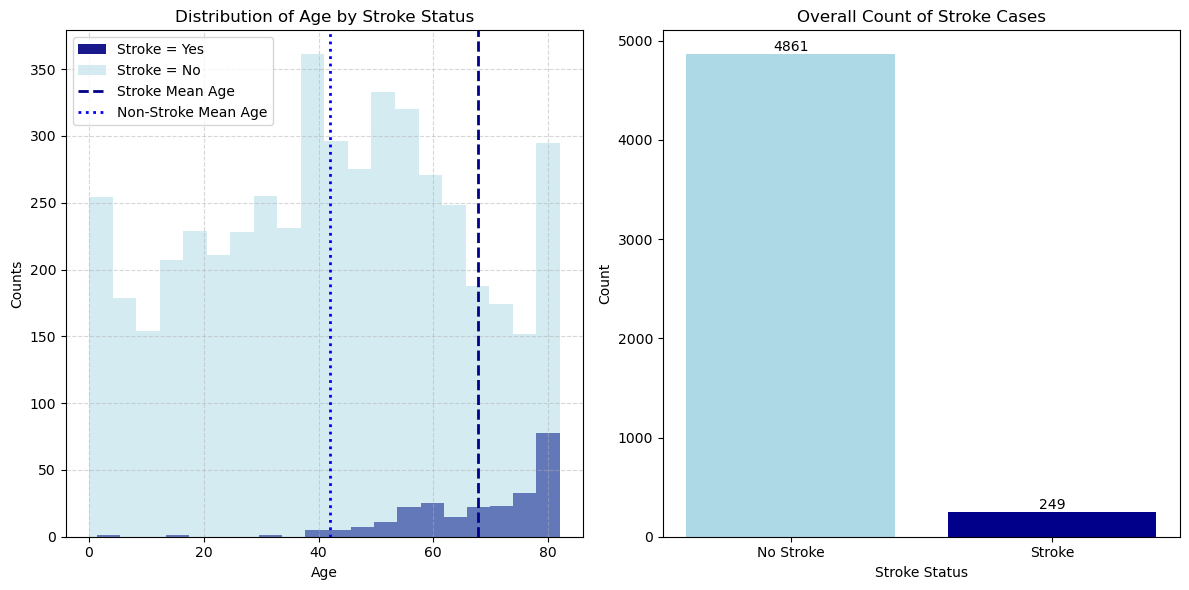

In [18]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram of age distribution for stroke status
ax1.hist(stroke_yes, bins=20, alpha=0.9, color='navy', label='Stroke = Yes')  # Dark color
ax1.hist(stroke_no, bins=20, alpha=0.5, color='lightblue', label='Stroke = No')  # Light color

# Plot mean lines for each category
ax1.axvline(x=stroke_yes.mean(), color='darkblue', linestyle='--', linewidth=2, label='Stroke Mean Age')
ax1.axvline(x=stroke_no.mean(), color='blue', linestyle=':', linewidth=2, label='Non-Stroke Mean Age')

# Add grid lines
ax1.grid(True, linestyle='--', alpha=0.5)

# Add title and labels
ax1.set_title('Distribution of Age by Stroke Status')
ax1.set_xlabel('Age')
ax1.set_ylabel('Counts')

# Adjust legend position
ax1.legend(loc='upper left')

# Plot bar plot of overall count of stroke and non-stroke cases
stroke_counts = df['stroke'].value_counts()
ax2.bar(['No Stroke', 'Stroke'], stroke_counts, color=['lightblue', 'darkblue'])

# Add labels to bars
for i, count in enumerate(stroke_counts):
    ax2.text(i, count, str(count), ha='center', va='bottom')

# Add title and labels
ax2.set_title('Overall Count of Stroke Cases')
ax2.set_xlabel('Stroke Status')
ax2.set_ylabel('Count')

# Show plot
plt.tight_layout()
plt.savefig('figures/stroke_histogram.png')
plt.show()


From our histogram, we see that the class balance is very one sided, there is significantly more cases of non-stroke than stroke, which tells us our model will not perform well.

The histogram analysis indicates a visually distinct difference in the mean age between the two groups, with stroke victims generally exhibiting older ages compared to non-stroke victims. However, the bar graph highlights a limitation in the dataset, particularly the scarcity of observations pertaining to stroke cases. Consequently, this dataset's imbalance may introduce a significant bias towards predicting the absence of stroke, potentially resulting in elevated false-negative predictions when the model is applied to new and unseen data.

A two-sample t-test was conducted to quantitatively assess the difference in means of age between stroke and non-stroke classes.

$H_0$: There is no difference between these two populations. $\mu_a = \mu_b$

$H_1$: There is a difference between these two populations. $\mu_a \neq \mu_b$

Significance Level $\alpha$ = 0.05


In [19]:
from scipy import stats
# hypothesis test

stroke_mean = np.mean(stroke_yes) 
nonstroke_mean = np.mean(stroke_no)
print(f'Stroke Mean Age: {round(stroke_mean, 2)}')
print(f'Non-stroke Mean Age: {round(nonstroke_mean, 2)}')

# we can use the built in function: ttest_ind
t_statistic, p_value = stats.ttest_ind(stroke_yes, stroke_no, alternative = 'two-sided') 

print(f't_statistic: {t_statistic}')
print(f'p_value: {p_value}')

alpha = 0.05
if p_value < 0.05:
    print('Reject the Null Hypothesis, the test is significant (p-value < 0.05)')
else: 
    print('Can not Reject the Null Hypothesis, the test is not significant (p-value >= 0.05)')

Stroke Mean Age: 67.73
Non-stroke Mean Age: 41.97
t_statistic: 18.08083426887953
p_value: 7.0307775129939774e-71
Reject the Null Hypothesis, the test is significant (p-value < 0.05)



The results of the t-test led to the rejection of the null hypothesis, providing strong evidence that age is a significant determinant of stroke. This implies that age will likely possess a high coefficient when training our logistic regression model.

In [20]:
# drop [ever_married_Yes], ['work_type_children], [work_type_Self-employed], [id]
df_encoded.drop(['ever_married_Yes', 'work_type_children', 'work_type_Self-employed', 'id'], axis = 1, inplace = True)

We have removed the strongly correlated variables and are comfortable with starting our modelling process

## Logistic Regression <a name="Logistic"></a>

- Run a Logistic Regression model using stats package
- Evaluate model with confusion matrix and F1 scores

In [21]:
import statsmodels.api as sm

# target
y = df_encoded['stroke']
# features
X = df_encoded.drop('stroke', axis=1)

# !! Add constant to our X !!
X_0 = sm.add_constant(X)

In [22]:
X_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   const                           5110 non-null   float64
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   avg_glucose_level               5110 non-null   float64
 5   bmi                             5110 non-null   float64
 6   gender_Male                     5110 non-null   uint8  
 7   gender_Other                    5110 non-null   uint8  
 8   work_type_Never_worked          5110 non-null   uint8  
 9   work_type_Private               5110 non-null   uint8  
 10  Residence_type_Urban            5110 non-null   uint8  
 11  smoking_status_formerly smoked  5110 non-null   uint8  
 12  smoking_status_never smoked     51

In [23]:
# Instantiate the logistic regression model 
logreg = sm.Logit(y.astype(float), X_0.astype(float))

In [24]:
# Fit the model (this returns a separate object with the parameters)
logreg_results = logreg.fit()

# Display the results 
logreg_results.summary()

         Current function value: 0.155030
         Iterations: 35


c:\Users\trann\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stroke   No. Observations:                 5110
Model:                          Logit   Df Residuals:                     5096
Method:                           MLE   Df Model:                           13
Date:                Wed, 17 Apr 2024   Pseudo R-squ.:                  0.2040
Time:                        20:57:21   Log-Likelihood:                -792.20
converged:                      False   LL-Null:                       -995.19
Covariance Type:            nonrobust   LLR p-value:                 1.230e-78
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -7.7438      0.552    -14.036      0.000      -8.825      -6.662
age                                0.0708      0.005     13.111      0.000       0.060       0.081
hypertension                       0.4046      0.164      2.460      0.014       0.082       0.727
heart_disease                      0.2921      0.191      1.533      0.125      -0.081       0.666
avg_glucose_level                  0.0041      0.001      3.400      0.001       0.002       0.006
bmi                               -0.0013      0.011     -0.118      0.906      -0.023       0.021
gender_Male                        0.0089      0.141      0.063      0.950      -0.268       0.286
gender_Other                      -3.3530     66.450     -0.050      0.960    -133.592     126.886
work_type_Never_worked           -16.4053   1.78e+04     -0.001      0.999   -3.48e+04    3.48e+04
work_type_Private                  0.2672      0.142      1.885      0.059      -0.011       0.545
Residence_type_Urban               0.0915      0.138      0.663      0.507      -0.179       0.362
smoking_status_formerly smoked     0.0451      0.206      0.218      0.827      -0.359       0.450
smoking_status_never smoked       -0.1547      0.196     -0.789      0.430      -0.539       0.230
smoking_status_smokes              0.1465      0.231      0.635      0.525      -0.306       0.599
==================================================================================================
"""

In [25]:
# Extract coefficients, t-stats, and p-values from the model summary excluding the constant term
coefficients = logreg_results.params.drop('const')
z_stats = logreg_results.tvalues.drop('const')
p_values = logreg_results.pvalues.drop('const')

# Create a DataFrame to store the coefficients, t-stats, and p-values
summary_df = pd.DataFrame({'Coefficient': coefficients,
                           'Z-Statistic': z_stats,
                           'P-Value': p_values})

# check significance
summary_df['P-value < 0.05'] = np.where(summary_df['P-Value'] < 0.05, 'Significant', 'Not Significant')

# odds ratio
summary_df['odds_ratio'] = np.exp(summary_df['Coefficient']).round(3)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF values for each feature
vif_values = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create a DataFrame to store the VIF values
vif_df = pd.DataFrame({'VIF': vif_values}, index=X.columns)

# Merge VIF DataFrame with the existing summary DataFrame
summary_df = pd.merge(summary_df, vif_df, left_index=True, right_index=True, how='left')

from tabulate import tabulate

# Convert DataFrame to Markdown table format
markdown_table = tabulate(summary_df, headers='keys', tablefmt='pipe', floatfmt='.3f', stralign='right')

# Print Markdown table
print(markdown_table)

|                                |   Coefficient |   Z-Statistic |   P-Value |   P-value < 0.05 |   odds_ratio |    VIF |
|-------------------------------:|--------------:|--------------:|----------:|-----------------:|-------------:|-------:|
|                            age |         0.071 |        13.111 |     0.000 |      Significant |        1.073 |  6.695 |
|                   hypertension |         0.405 |         2.460 |     0.014 |      Significant |        1.499 |  1.205 |
|                  heart_disease |         0.292 |         1.533 |     0.125 |  Not Significant |        1.339 |  1.161 |
|              avg_glucose_level |         0.004 |         3.400 |     0.001 |      Significant |        1.004 |  6.188 |
|                            bmi |        -0.001 |        -0.118 |     0.906 |  Not Significant |        0.999 | 10.439 |
|                    gender_Male |         0.009 |         0.063 |     0.950 |  Not Significant |        1.009 |  1.673 |
|                   gend

In [26]:
print(summary_df.to_string())

                                Coefficient  Z-Statistic       P-Value   P-value < 0.05  odds_ratio        VIF
age                                0.070759    13.111353  2.834943e-39      Significant       1.073   6.694922
hypertension                       0.404587     2.460286  1.388262e-02      Significant       1.499   1.205089
heart_disease                      0.292121     1.533414  1.251740e-01  Not Significant       1.339   1.161208
avg_glucose_level                  0.004061     3.399995  6.738713e-04      Significant       1.004   6.188126
bmi                               -0.001324    -0.117977  9.060857e-01  Not Significant       0.999  10.439046
gender_Male                        0.008921     0.063058  9.497203e-01  Not Significant       1.009   1.672654
gender_Other                      -3.353043    -0.050460  9.597559e-01  Not Significant       0.035   1.002318
work_type_Never_worked           -16.405281    -0.000924  9.992627e-01  Not Significant       0.000   1.017193
w

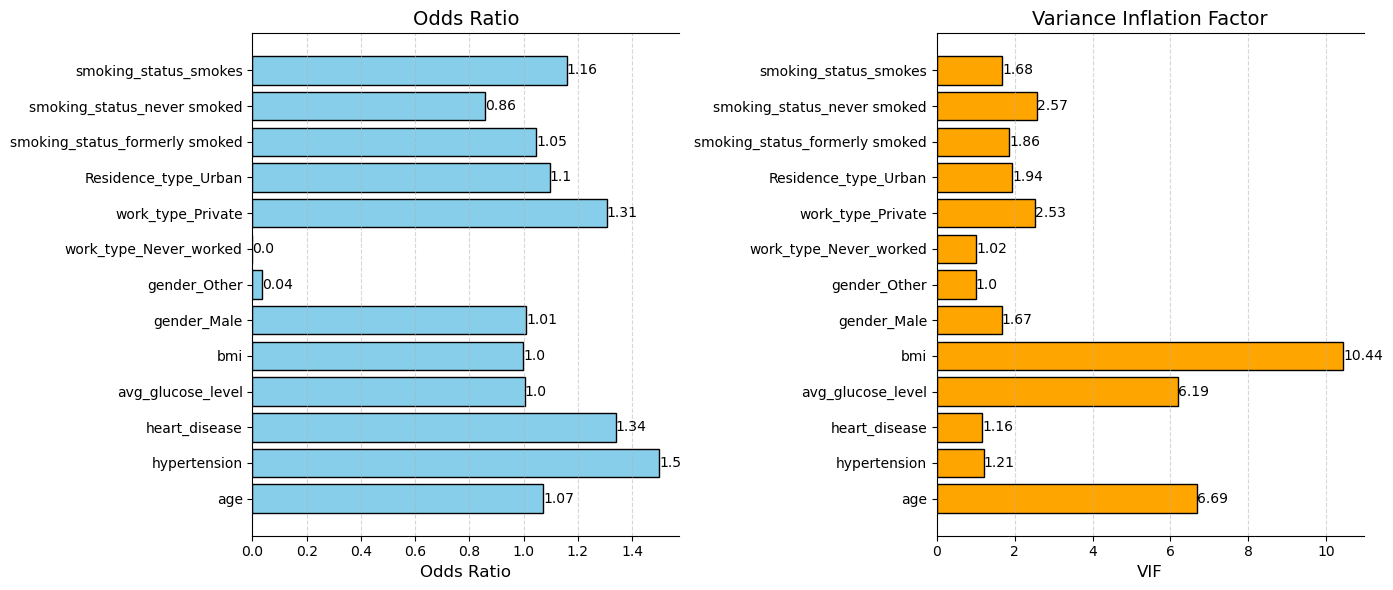

In [27]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the odds ratio in the first subplot
bars1 = axes[0].barh(summary_df.index, summary_df['odds_ratio'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Odds Ratio', fontsize=12)
axes[0].set_title('Odds Ratio', fontsize=14)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# Add labels to the bars in the first subplot
for bar in bars1:
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height()/2, f'{round(width, 2)}', va='center', ha='left', fontsize=10)

# Plot the VIF values in the second subplot
bars2 = axes[1].barh(summary_df.index, summary_df['VIF'], color='orange', edgecolor='black')
axes[1].set_xlabel('VIF', fontsize=12)
axes[1].set_title('Variance Inflation Factor', fontsize=14)
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

# Add labels to the bars in the second subplot
for bar in bars2:
    width = bar.get_width()
    axes[1].text(width, bar.get_y() + bar.get_height()/2, f'{round(width, 2)}', va='center', ha='left', fontsize=10)

for ax in axes:
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('figures/odds_ratio_and_vif.png', bbox_inches='tight')

# Show the plot
plt.show()


[bmi], [gender_Male], [gender_Other], [work_type_Never_worked], [smoking_status_formerly smoked], [smoking_status_smokes] have pvalues above 0.05

These are the columns to consider dropping or changing after we evaluate the accuracy

In [28]:
# Getting the model predictions as probabilities
y_prob = logreg_results.predict(X_0)

# Going from soft predictions (probabilities) to hard predictions (1 or 0)
y_pred = np.where(y_prob >= 0.5, 1, 0)

# True labels
y_true = y

# Calculating accuracy 
acc = (y_pred == y_true).mean()

thresholds = np.arange(0, 1.1, 0.1)

accuracies = []
for p in thresholds:
    accuracies.append(np.mean((y_prob > p) == y_true))

# Create DataFrame to store accuracy values
accuracy_df = pd.DataFrame({'Decision Threshold': thresholds, 'Accuracy': accuracies})

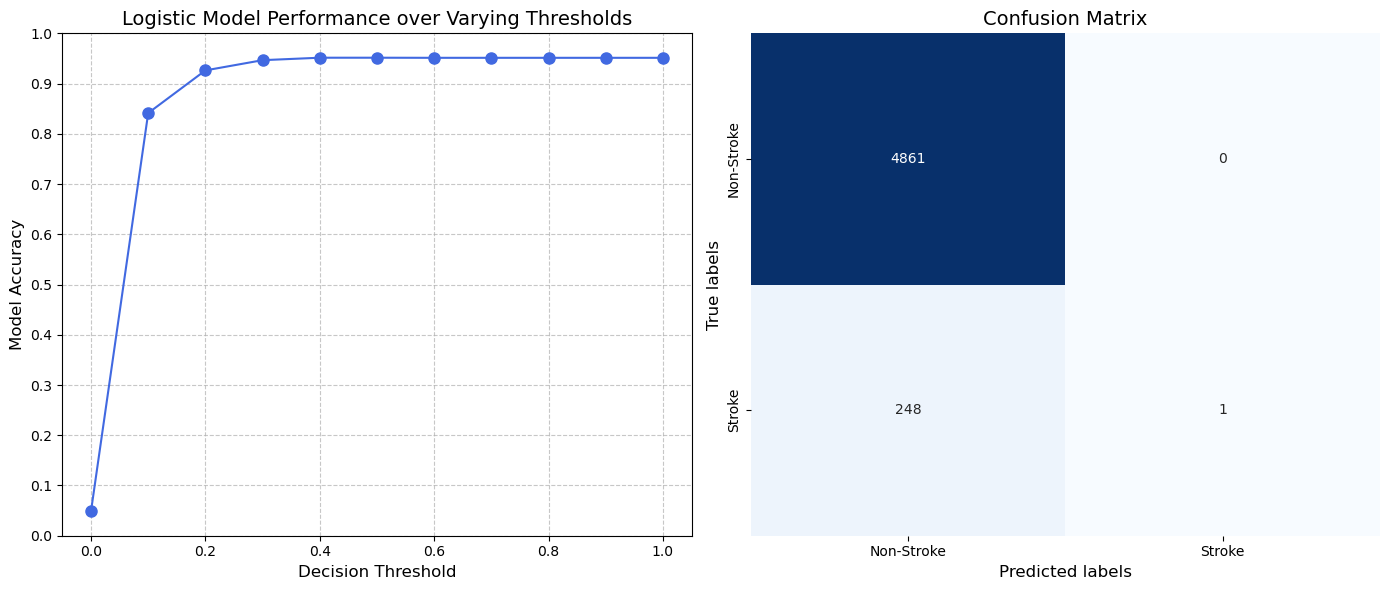

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define labels
label_names = ['Non-Stroke', 'Stroke']
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy over varying thresholds
axes[0].plot(accuracy_df['Decision Threshold'], accuracy_df['Accuracy'], marker='o', linestyle='-', color='royalblue', markersize=8)
axes[0].set_xlabel('Decision Threshold', fontsize=12)
axes[0].set_ylabel('Model Accuracy', fontsize=12)
axes[0].set_title('Logistic Model Performance over Varying Thresholds', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].tick_params(labelsize=10)
axes[0].set_yticks(np.arange(0, 1.1, 0.1))



# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, ax=axes[1],
            xticklabels=label_names, yticklabels=label_names)
axes[1].set_xlabel('Predicted labels', fontsize=12)
axes[1].set_ylabel('True labels', fontsize=12)
axes[1].set_title('Confusion Matrix', fontsize=14)
axes[1].tick_params(labelsize=10)
axes[1].grid(False)

plt.tight_layout()
plt.savefig('figures/accuracy_and_confusion_matrix_subplots.png')
plt.show()


# SMOTE Modeling <a name="Smote"></a>
- SMOTE, Synthetic Minority Over-sampling Technique
    - generates synthetic samples for the minority class to balance class distribution
    - uses KNN to artifically upsample the minority class
- use smote to over-sample to balance the target class
- create a new logistic model and check accuracy

In [ ]:
# to make a smote model, need to make a train and test split because it is an sklearn model
from sklearn.model_selection import train_test_split
# import smote 
from imblearn.over_sampling import SMOTE

In [ ]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

In [ ]:
# check target before and after SMOTE resample
print('Without SMOTE:')
print(y.value_counts())
print('')
print('With SMOTE:')
print(y_train_resampled.value_counts())

Without SMOTE:
0    4861
1     249
Name: stroke, dtype: int64

With SMOTE:
1    4861
0    4861
Name: stroke, dtype: int64


The unbalanced target class was upsampled from 249 to 4861, similar to the non-stroke class <br>

We can now fit a logisitic model to this data and inspect accuracy, this requires the sklearn library

In [ ]:
# import logreg model
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg_model2 = LogisticRegression(max_iter = 1000)

# fit
logreg_model2.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions on the test data
y_pred_2 = logreg_model2.predict(X)

# Calculate and print accuracy
accuracy = accuracy_score(y, y_pred_2)*100
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 81.41


The accuracy of the model has decreased to 82%, however, we can view the advanced metrics now <br>




In [ ]:
# create confusion matrix
conf_matrix = confusion_matrix(y, y_pred_2)
confusion_df = pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], 
                            index=['Actual Negative', 'Actual Positive'])

#view matrix
confusion_df

,Predicted Negative,Predicted Positive
Actual Negative,4045,816
Actual Positive,134,115


In [ ]:

# Print classification report
class_report = classification_report(y, y_pred_2)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.89      4861
           1       0.12      0.46      0.19       249

    accuracy                           0.81      5110
   macro avg       0.55      0.65      0.54      5110
weighted avg       0.93      0.81      0.86      5110



The accuracy of the model dropped from 0.95 to 0.82 after implementing SMOTE. SMOTE tends to perform optimally when dealing with minimal class imbalances, as excessive resampling from the smaller class can introduce more noise into the oversampled class

# Summary <a name="Summary"></a>
 
Cleaning
- mean-imputed missing BMI values
- there was a large class imbalance in stroke data (5-95)

Model
- trained a logistic regression model to predict stroke
- accuracy of 95%, but this was mainly caused by class imbalance
- with a decision threshold of 0.1 we had an accuracy of 84% (very large class imbalance)

SMOTE
- tried to alleviate class imbalance with SMOTE
- reduced accuracy to 82%